# Kmeans clustering for getting wordcloud
This program is supposed to behave in the similar manner as the R program Kmeans_minimum_dictioary
Some of the steps that needs to be performed
1. Read the cases from the database which have been normalized earlier
2. Perform cleanup of the text: punctuation, spaces digits.. I guess the cleanup will be done using the nltk
3. Find the tf-idf score normalized by the length of the documents
4. Find the kmeans cluster
5. Create word clouds based on the clusters

In [31]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


In [3]:


#read the cases that have already been normalized...we have supplied from the windows machine
fname="output_autonormalizedjim_cases.txt"
lines = [line.rstrip('\\n') for line in open(fname)]
#print(lines[2:80])

#read the stop words
stopwordsFile = open('stopwordsss.txt', 'r')
stopwords=stopwordsFile.read()
stopwordList=stopwords.split(",")
#print(stopwordList)

the tf-idf by default is calcluated as tf : that is nuber of time the word has appeaered * (idf) which is
idf = np.log(float(n_samples) / df) + 1.0

Note: 
##### tf is the number of the times the word appeared in the particular document. 
##### df is the number of times the word appeared in all the documents in the corpus. It is a binary count that is if the words appeared it is counted 1 else 0. 
so df(flatline) is 158 although the total frequnecy (number of times is appeared. in some document it might appear 2 times )is 186


In the Jim data input we have analyzed the tf-idf for the word "flatline"
tf=2
the idf is 3.538 as n_samples=2000 and df=158 so the tfidf is 7.06

(norm=None, use_idf=True, smooth_idf=True, sublinear_tf=False)
this is calculated as tf*(log(2000/158)+1)
7.06


if the nomrmalise is l2 then divide by the squraeroot . in case there is only one term then the output will be 1
(norm=u'l2', use_idf=True, smooth_idf=True, sublinear_tf=False)

in this cae the evry value is divided bby the length of the vector. SO if there is only one keyword then the tfidf weight will be 1

if we use sublinear_tf=Ttue then tf will be calcualted as 1+log(tf) so
(1+log(2))*(log(2000/158)+1)=5.98103925314

In [351]:
#now we need to vectorize the corpus
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=0.006,stop_words=stopwordList,strip_accents='unicode',norm='l2',sublinear_tf=True)
#maximum is 4997
tfSparseMatrix = vectorizer.fit_transform(lines[0:4900])
print("Data dimensions: {}".format(tfSparseMatrix.shape))



Data dimensions: (4900, 185)


In [352]:
#convert the dtm to numpy array
tfDtm = tfSparseMatrix.toarray()
tfDtm=np.array(tfDtm)
#print(tfDtm[1,])

This is to get the raw count of the tokens. 
The countvectorization is good way to find out the vocabulary and the raw count of the words...
I am not sure if this is absolutely required for the analyziz though

In [353]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(min_df=0.006,stop_words=stopwordList,strip_accents='unicode',binary=False)
rawdtm = count_vect.fit_transform(lines[0:4900])
vocab=count_vect.get_feature_names()
#convert the dtm to regular array
countDtm = rawdtm.toarray()
#convert the dtm to numpy array
countDtm=np.array(countDtm)
print(countDtm)
#need to convert it to numpy array so that we can easily perform the operations on it
vocab = np.array(vocab)


[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 1 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


In [354]:
print("check the sizes of the two dtm that we have got")
print("Data dimensions: {}".format(countDtm.shape)) 
print("Data dimensions: {}".format(tfDtm.shape)) 
#print(rawdtm)
#print(vocab[1:20])
print(count_vect.vocabulary_.get("wind_speed"))
print(count_vect.vocabulary_.get("flatline"))
#print(lines[0:10])
print(vocab[79])



check the sizes of the two dtm that we have got
Data dimensions: (4900, 185)
Data dimensions: (4900, 185)
183
58
inlet_pressure


#### In order to get the index of a word from the dictionary the following function will help

In [355]:
def getKeywordIndexInVocabulary(vocab,keyword):
    idx = list(vocab).index(keyword)
    return(idx)

#test
print(getKeywordIndexInVocabulary(vocab,"turbine"))

172


#### In order to get the documents containing a word


In [356]:
def getDocumentsContainingKeywords(countDtm,vocab,keyword):
    #GET THE COLUMN NUM OF THE KEYWORD
    keywordIndex=getKeywordIndexInVocabulary(vocab,keyword)
    tt=list(countDtm[:,keywordIndex]>0)
    res=[]
    for idx,w in enumerate(tt):
        if(w==True):
            res.append(idx)
    return(res)

print(getDocumentsContainingKeywords(countDtm,vocab,"ti"))

[127, 224, 227, 348, 362, 395, 531, 551, 558, 569, 597, 675, 819, 875, 880, 932, 937, 1455, 1463, 1530, 1887, 2044, 2115, 2515, 3489, 3517, 3520, 3527, 3626, 3630, 3633, 3652, 3693, 3775, 3781, 3827, 3833, 3869, 3968, 3971, 4064, 4397, 4405, 4585, 4612]


#### Function to get the keywords in a given document
=>we are using teh flatnonzero() function to find out which indexes in the numpy array dtm are nonzero. the flatten version of the nonzero function will return an array

=>The vocab is also a numpy array and supports multiple indexes passed in the form of the array. 
We are finally converting the result to a list

In [357]:
#dtm is either the tf dtm or the count dtm
def getKeywordsOfDocument(dtm,vocab,docNo):
    nn=np.flatnonzero(dtm[docNo,])
    print(nn)
    #print(nn[1])
    #get the corresponding word from the vocabulary list
    return(vocab[nn].tolist())

#test
print(getKeywordsOfDocument(countDtm,vocab,1))

[ 58  86 127 145 172 183]
['flatline', 'issue', 'power', 'sensor', 'turbine', 'wind_speed']


#### Function to get the frequency of a keywrd in the vocabulary
The vocabulary that is obtained from the countvectorizer contains a list of the keywords only. We may want to get the frequency of the word appearing the corpus


In [358]:
#columm sum
freqsum=np.sum(countDtm,axis=0)

#for each of the vocabulary word create a dictionary containing the count
freqDict=[]
for idx,v in enumerate(vocab):
    freqDict.append({'word':v,'count':freqsum[idx]})

    
def getFreqOfKeyword(freqDict,keyword):
    for key in freqDict:
        if(key['word']==keyword):
            return(key['count'])

#test
print(getFreqOfKeyword(freqDict,"temperature"))


1222


------------
## Perfoming the Kmeans clustering using the tf sparse matrix
We can first see the shape of teh data to judge how many clusters will make the sense. This cane be done by using PCA and redcing the tfmatrix to a dense matrix. After that we should apply the kmeans clustering to distribute the documents

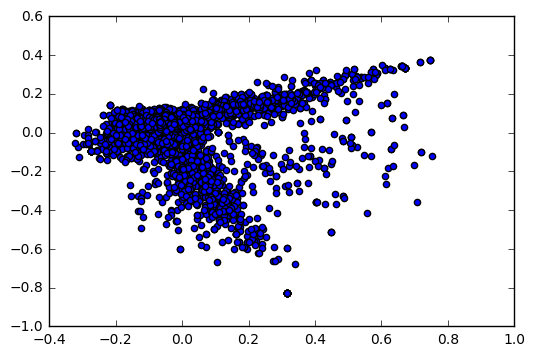

In [359]:

X=tfSparseMatrix.todense()
pca = PCA(n_components=2).fit(X)
data2D = pca.transform(X)
plt.scatter(data2D[:,0], data2D[:,1])
plt.show()

From the image we can see that there are atleast 3 clusters. so we can run the algorithm with k=3

In [360]:
from sklearn.cluster import KMeans
#the max_iter is how many iterations before the convergence is assumed
#n_init is the number of times the algo is run
K_Cluster=4
km = KMeans(n_clusters = K_Cluster, init = 'k-means++', max_iter = 1000, n_init = 10, verbose = False)
#you need to call the km.fit_predict so that the kmeans cane be run and then each of the points can be assigned a cluster index
km.fit_predict(tfSparseMatrix)

print(len(km.labels_))

4900


#### Plotting function to see how the clustering performed

In [361]:
def plotClusters(tfSparseMatrix,kmResults):
    X=tfSparseMatrix.todense()
    
    pca = PCA(n_components=2).fit(X)
    data2D = pca.transform(X)
    
    plt.scatter(data2D[:,0], data2D[:,1],c=kmResults.labels_)
    #plt.show()
    centers2D = pca.transform(kmResults.cluster_centers_)
    #plt.hold(True)
    plt.scatter(centers2D[:,0], centers2D[:,1],
                marker='x', s=200, linewidths=3, c='r')
    plt.show()
    

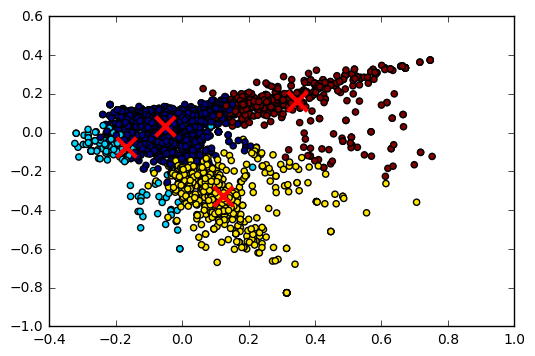

(array([0, 1, 2, 3], dtype=int32), array([3550,  310,  555,  485]))

In [362]:
plotClusters(tfSparseMatrix,km) 
#GET THE DETAILS ABOUT THE CLUSTERS
np.unique(km.labels_, return_counts=True)


### Find the keywords for the wordcloud
Now we want to find out the high frequency keywords for each of the clusters
In doing so se want to find the number of keywords proportional to the size of the cluster

#### Get the number of words to be used from each of the cluster. 
Additionally if the size of the cluster is small and the proportion is coming to be less than 10 then make it 10

In [363]:
def getNumberOfWordsForCluster(km,clusterNum,N):
    ret=np.unique(km.labels_, return_counts=True)
    clusterSize=ret[1][clusterNum]
    totalWords=float(clusterSize/N)*100
    print(totalWords)
    if(totalWords<10):
        return(10)
    return(int(totalWords)+1)

print(getNumberOfWordsForCluster(km,2,2000))

27.750000000000004
28


##### Seperate out the text into different clusters 

In [364]:
#first create a dictionary that will store the cases from the clusters seperately
text={}
for i,cluster in enumerate(km.labels_):
    oneDocument = lines[i]
    if cluster not in text.keys():
        text[cluster] = oneDocument
    else:
        text[cluster] += oneDocument


cases={}
for i,cluster in enumerate(km.labels_):
    if cluster not in cases.keys():
        cases[cluster] = str(i)+","
    else:
        cases[cluster] += str(i)+","

#print(cases)



In [365]:
#not required.Earlier using it for checking if the freqdist gave a word that is not in the vocab

# def checkVocab(word):
#     for v in vocab:
#         if(v==word):
#             return(True)
#     return(False)

# print(checkVocab("air1"))

# #print(counts[0].get)
# for cluster in range(K_Cluster):
#     for word, frequency in counts[cluster].most_common(100):
#         if(checkVocab(word)==False):        
#     #      print(u'{};{}'.format(word, frequency))
#     # else:
#     #     print(u'{} not found'.format(word))
#             wordsNotInVocab.append(word)
    

# print(wordsNotInVocab)



In [366]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from collections import defaultdict
from string import punctuation
from heapq import nlargest
import nltk

keywords = {}
counts={}
wordsNotInVocab=[]
#for each cluster find out the word tokens. using the FreqDist function find out the frequency of each of these words 
#in the cluster. We are taking the top100 words from each cluster. 
# I guess we need to also make sure that these words belong to the vocab as well
for cluster in range(K_Cluster):
    word_sent = word_tokenize(text[cluster].lower())
    #make sure that the word in not a stop word
    word_sent=[word for word in word_sent if word not in stopwordList]
    #make sure the word is from the vocab
    word_sent=[word for word in word_sent if word in vocab]
    freq = FreqDist(word_sent)
    keywords[cluster] = nlargest(100, freq, key=freq.get)
    counts[cluster]=freq

# print("print first keywords")
# print(keywords.get(0))
# print("print second keywords")
# print(keywords.get(1))
# print("print thris keywords")
# print(keywords.get(2))
   
    
#this is the logic to get the top words..but it looks like that it is hard coded for the 3 clusters only
#unique_keys={}
# for cluster in range(3):
#     other_clusters=list(set(range(3))-set([cluster]))
#     keys_other_clusters=set(keywords[other_clusters[0]]).union(set(keywords[other_clusters[1]]))
#     unique=set(keywords[cluster])-keys_other_clusters
#     print(unique)
#     #getNumberOfWordsForCluster(km,cluster,2000)
#     unique_keys[cluster]=nlargest(getNumberOfWordsForCluster(km,cluster,2000), unique, key=counts[cluster].get)

#print(unique_keys)
wordList=[]
for cluster in range(K_Cluster):
    #get some words
    wordList.append(nlargest(getNumberOfWordsForCluster(km,cluster,2000), keywords[cluster], key=counts[cluster].get))


#we get a list of list one for each cluster    
#flatten the list using http://stackoverflow.com/questions/952914/making-a-flat-list-out-of-list-of-lists-in-python    
import itertools
mergedWordList = list(itertools.chain(*wordList))

#find the unique keywords by using the set operations
myset = set(mergedWordList)
wordListFinal=list(myset)

print(len(wordListFinal))

177.5
15.5
27.750000000000004
24.25
103


#### Wordcloud
Now we have the words that should be shown in the wordcloud. But the unique_keys doesnot store the frequency of the words. The frequency of the words for the particular cluster is in counts. So we will combine them together to get a single dictionary
##### wordCloudDataForImage: this data structure is the dictionary that is used by the wordcloud program
##### wordCloudDataForService: this is the datastructure that will be used by the end points. it containes the list of words, freq(across all the clusters i.e. the vocab freq), and documents it occur

#### Function to generate the wordcloud image
This generate the image using the wordcloud library

In [367]:

def generateWordCloud(wordCloudDataForImage):
    from wordcloud import WordCloud

    #somehow the command wc.generate_from_frequencies(wordCloudData) is giving issues. so copied some code from the wordcloud 
    #https://github.com/amueller/word_cloud/blob/master/wordcloud/wordcloud.py generate_from_frequencies().

    max_words=len(wordCloudDataForImage)-1
    from operator import itemgetter
    item1 = itemgetter(1)
    frequencies=wordCloudData
    frequencies = sorted(frequencies.items(), key=item1, reverse=True)
    #print(frequencies)
    frequencies = frequencies[:max_words]
    # largest entry will be 1
    max_frequency = float(frequencies[0][1])

    frequencies = [(word, freq / max_frequency)
                   for word, freq in frequencies]


    #after the preprocessing calling the wordcloud function
    wc = WordCloud(max_words=max_words )
    wc.generate_from_frequencies(frequencies)
    import matplotlib.pyplot as plt
    plt.axis("off")
    plt.imshow(wc)
    plt.show()
    #frequencies = [ (word, freq / max_frequency) for word, freq in wordCloudData ]

Prepare the data structure that will work towards creating the image and the wordlist

103


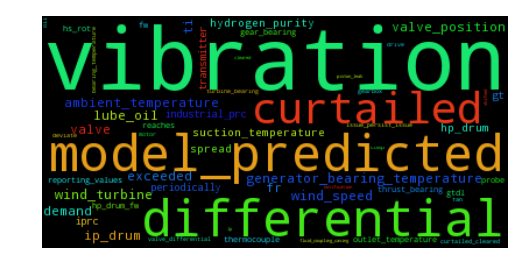

In [336]:
#the wordcloud class requires a dictionary with dict[word]=float(freq)
wordCloudDataForImage={}
wordCloudDataForService=[]
# for cluster in range(3):
#     for word in unique_keys[cluster]:
#         #wordCloudData.append({"keyword":word,"frequency":counts[cluster][word]})
#         wordCloudDataForImage[word]=float(counts[cluster][word])
#         wordCloudDataForService.append({"keyword":word,"frequency":getFreqOfKeyword(freqDict,word),
#                                         "docs":getDocumentsContainingKeywords(countDtm,vocab,word)})

        
for word in wordListFinal:
    #wordCloudData.append({"keyword":word,"frequency":counts[cluster][word]})
    wordCloudDataForImage[word]=float(getFreqOfKeyword(freqDict,word))
    wordCloudDataForService.append({"keyword":word,"frequency":getFreqOfKeyword(freqDict,word),
                                    "docs":getDocumentsContainingKeywords(countDtm,vocab,word)})

print(len(wordCloudDataForImage))
#print(wordCloudDataForService)
generateWordCloud(wordCloudDataForImage)
#print(wordCloudDataForService['keyword'])

In [183]:
# from collections import defaultdict
# clusters = defaultdict(list)

# for i, label in enumerate(km.labels_): 
#     clusters[label].append(lines[i])
# for label, descriptions in clusters.items():
#     #print('---------- Cluster {}'.format(label+1))
#     for desc in descriptions[:10]:
#         #print(desc)